# **NLP For Finance: Exploration and Basic Models**

Natural language processing (NLP) enables us to analyze financial news
and evaluate the market sentiment. In the past, the volume of textual data was manageable enough to be manually analyzed by teams of human experts, but recent growth is intractable, so we need NLP to overcome this problem. In this project, we will go over different NLP techniques—from basic to advanced—and perform sentiment analysis over stock market news, categorizing the news into **positive**, **negative** or **neutral**.










## Goals
In this notebook:
*   Understand the task of sentiment analysis within the domain of finance.
*   Apply NLP pre-processing techniques to filter our datasets.
*   Build a baseline model for the task of financial news sentiment classification.
*   Assess and visualize our results using a confusion matrix.

# **Sentiment analysis within the domain of finance**

In [ ]:
#@title Run this to setup the libraries and download the dataset { display-mode: "form" }
# Run this every time you open the spreadsheet
%load_ext autoreload
%autoreload 2
from collections import Counter
from importlib.machinery import SourceFileLoader
import numpy as np
from os.path import join
import os
import sys
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

with HiddenPrints():
    import nltk
    nltk.download('punkt', quiet=True)
    from nltk.stem import WordNetLemmatizer
    import seaborn as sns
    import matplotlib
    import matplotlib.pyplot as plt
    from nltk.tokenize import sent_tokenize, word_tokenize
    from nltk.stem.wordnet import WordNetLemmatizer
    from nltk.stem.porter import *
    from nltk.corpus import stopwords
    nltk.download('stopwords', quiet=True)
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    import pandas as pd
    from sklearn.metrics import multilabel_confusion_matrix
    from sklearn import metrics
    import gdown
    import string
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    pd.set_option('max_colwidth', 100)
    from sklearn.feature_extraction.text import CountVectorizer
    nltk.download('wordnet', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)

    # gdown.download('https://drive.google.com/uc?id=1q4U2gVY9tWEPdT6W-pdQpKmo152QqWLE', 'finance_train.csv', True)
    # gdown.download('https://drive.google.com/uc?id=1nIBqAsItwVEGVayYTgvybz7HeK0asom0', 'finance_test.csv', True)

    !wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv'
    !wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_train.csv'

    PUNCTUATION = '!#$%&()*,-./:;<=>?@^_`{|}~'

    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    # text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

def get_finance_train():
  df_train = pd.read_csv("finance_train.csv")
  return df_train
def get_finance_test():
  df_test = pd.read_csv("finance_test.csv")
  return df_test

def plot_word_cloud(text):
  text = text.Sentence.values
  wordcloud = WordCloud(
      width = 3000,
      height = 2000,
      background_color = 'black',
      stopwords = STOPWORDS).generate(str(text))
  fig = plt.figure(
      figsize = (10, 7),
      facecolor = 'k',
      edgecolor = 'k')
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.axis('off')
  plt.tight_layout(pad=0)
  plt.show()

def preprocess_data(df):
  sentences = df.Sentence.values
  labels = df.Label.values
  tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]
  filtered_sentences = [remove_stopwords(' '.join(tokenized_sentence)) for tokenized_sentence in tokenized_sentences]
  return filtered_sentences, labels

def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = ["Negative","Neutral","Positive"]
  df_cm = pd.DataFrame(cm,index =labels,columns = labels)
  fig = plt.figure(figsize=(7,6))
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  plt.close()

if 'not' in STOPWORDS:
  STOPWORDS.remove('not')
if 'no' in STOPWORDS:
  STOPWORDS.remove('no')

LABEL_MAP = {0 : "negative", 1 : "neutral", 2 : "positive"}
STOPWORD_SET = set(stopwords.words('english'))
SAMPLE_SENTENCE = 'I need to remove all these meaningless stopwords.'
SAMPLE_SOLUTION = ['need', 'remove', 'meaningless', 'stopwords']

plt.rcParams.update({'font.size': 22})
print ("Train & Test Files are loaded")


Train & Test Files are loaded


# **Apply NLP pre-processing techniques to filter our datasets.**

### **Exploring the Datasets**

Before we can filter our datasets, let us first read them in and explore.

#### **Simple Dataset Analysis**

We have two datasets: a train set and a test set. **Finance Train** contains all the raw input sentences and their sentiment labels. **Finance Test** contains a set of raw input sentences that we would like to predict the sentiment of. Let us begin with **Finance Train** and take a look at the existing labeled data.

Use the existing `get_finance_train()` function to obtain a `pandas` dataframe for **Finance Train** of input sentences and save it in a variable named `df_train`. Then print the first few lines of the dataframe using the `.head()` function.

In [ ]:
df_train = get_finance_train()
print(df_train.head())

                                                                                              Sentence  \
0                                                 Autotank Group is part of Aspo 's Systems Division .   
1  The contract includes design , construction , delivery of equipment , installation and commissio...   
2  Rapala said it estimates it will make savings of 1-2 mln eur a year by centralising its French o...   
3  The share capital of Alma Media Corporation (business ID 1944757-4)is EUR 45,031,513.80 and it i...   
4  The financial impact is estimated to be some 1.5 MEUR annual improvement in the division 's resu...   

   Label  
0      1  
1      1  
2      2  
3      1  
4      2  


#### **Dataset Size**

Find and print the number of sentences in the **Finance Train** dataset.

In [ ]:
print(len(df_train))
#df_train.shape

2037


#### **Test Dataset Analysis**

Use the existing `get_finance_test()` function to obtain a pandas dataframe for **Finance Test** of input sentences and save it in a variable named `df_test`. Then print the first few lines of the dataframe using the `.head()` function.

In [ ]:
df_test = get_finance_test()
print(df_test.head())

                                                                                              Sentence  \
0  In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating prof...   
1  Foundries division reports its sales increased by 9.7 % to EUR 63.1 mn from EUR 57.5 mn in the c...   
2                                               Financing of the project will come mainly from China .   
3  Sukhraj Dulai , of the 2900 block of Boni Sue Court , a cul-de-sac on the city 's north side , s...   
4  Finland 's leading metals group Outokumpu said its fourth-quarter net profit more than tripled o...   

   Label  
0      2  
1      2  
2      1  
3      1  
4      2  


#### **Dataset Size**

Find and print the number of sentences in the **Finance Test** dataset.

In [ ]:
print(df_test.shape)

(227, 2)


#### **Label mapping exploration**

Now we will give concrete mappings to our labels such that we may properly interpret the sentiment moving forward. We will use a Python object known as a `dictionary` to hold the association between each numeric label and its sentiment correlation and it will be saved in a variable named `LABEL_MAP`. Print out the `LABEL_MAP` variable and comment on what you see.

In [ ]:
print(LABEL_MAP)

{0: 'negative', 1: 'neutral', 2: 'positive'}


### Visualizing our Dataset Distribution ###

Let's visualize the class distribution (positive, negative, or neutral) for the news sentences in our training data!

#### **Dataset distribution visualization**

Properly observing and analyzing our data is a very important step in the machine learning pipeline. We need to know what our data looks like before we can take any steps to learn from it. So, let's visualize the class distributions for the news sentences in our training data!

To do so, you will utilize a line of code that first separates our input data based on the label. Then it will make a bar plot based on the number of sentences in each respective category. Use this line of code in the space provided below to create your plot!

`df_train.groupby('Label').Sentence.count().plot.bar(ylim=0)`

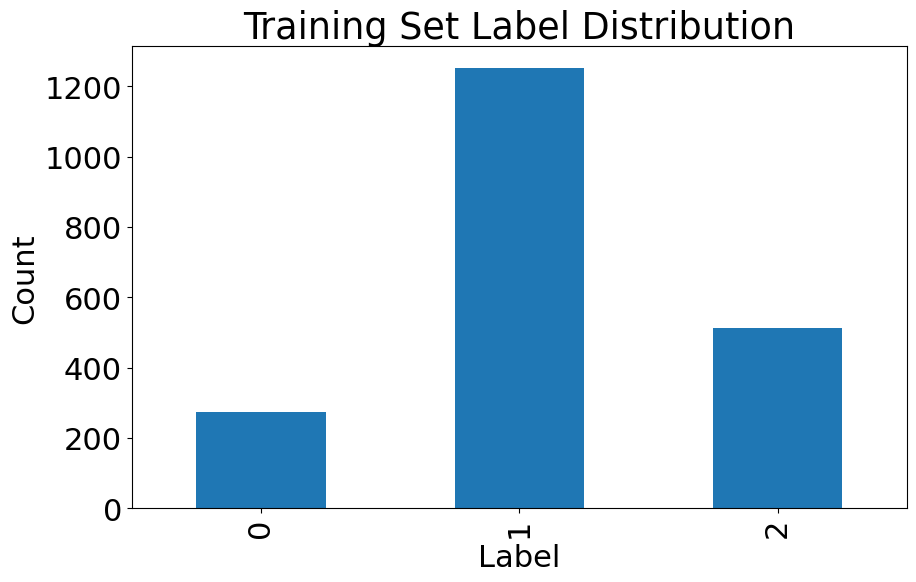

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.title('Training Set Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')

df_train.groupby('Label').Sentence.count().plot.bar(ylim=0)

plt.show()

## Word Clouds

Word clouds are graphical representations of word frequency that help us better visualize our data. They give greater prominence to words that appear more frequently in a source text.

Let's create and explore the word clouds for each class of data in our dataset!

#### **Negative Data Word Cloud**

Let's create a word cloud of all the sentences labeled with a negative sentiment! This will give us the chance to explore what particular words potentially influence the negative classification.

To do so, first let us obtain all the sentences from the dataset that have a negative label. Thus, we want sentences with `Label` equal to `0`. Filter the original `df_train` dataframe to obtain all the sentences with a negative label. After filtering, save the result in a variable named `negative_data`.

**Note: To filter a dataframe based on the value in a specified column, you can use the code structure: `negative_data = df_train[df_train[column_name] == value]`. Replace `column_name`, and `value` to appropriately filter the dataframe. Think about what `value` you would need to signify that the sentiment is negative.**

In [ ]:
negative_data = df_train[df_train['Label'] == 0]

Now we will create our word cloud. To do so, call the `plot_word_cloud(DATA)` function passing in your `negative_data` dataframe in place of `DATA`. Comment on what you notice in your word cloud!

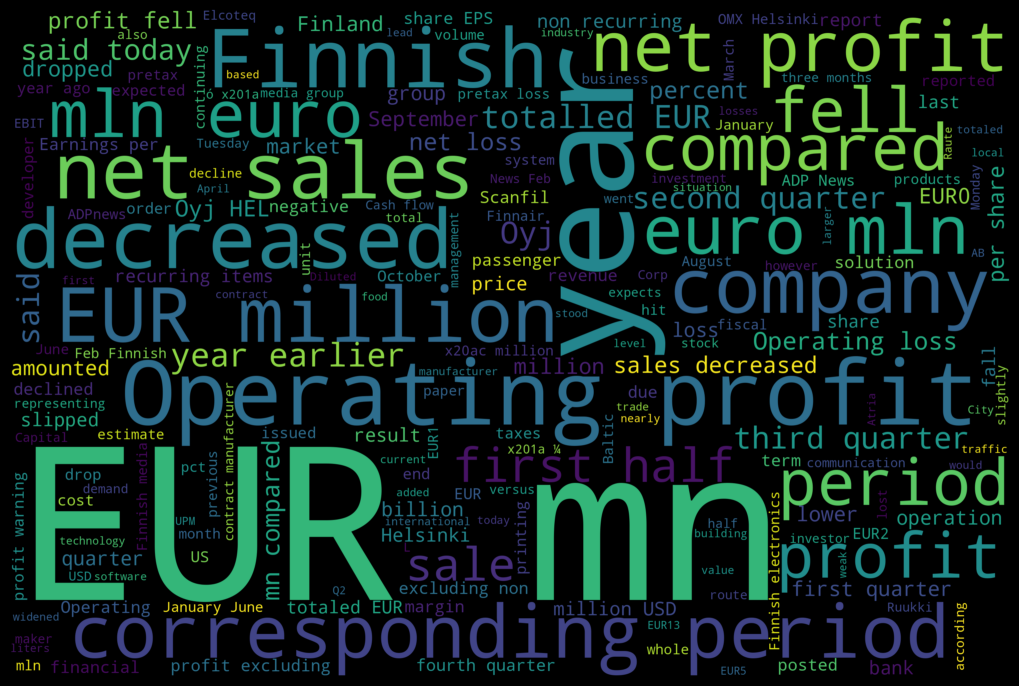

In [ ]:
plot_word_cloud(negative_data)

#### **Positive Data Word Cloud**

Now let's create a word cloud of all the sentences labeled with a positive sentiment!

Follow the sample process as above to filter the `df_train` dataframe, this time keeping the sentences with positive labels. After filtering, save the result in a variable named `positive_data`.

In [ ]:
positive_data = df_train[df_train['Label'] == 2]

Now we will create our word cloud. To do so, call the `plot_word_cloud(DATA)` function passing in your `positive_data` dataframe in place of `DATA`.

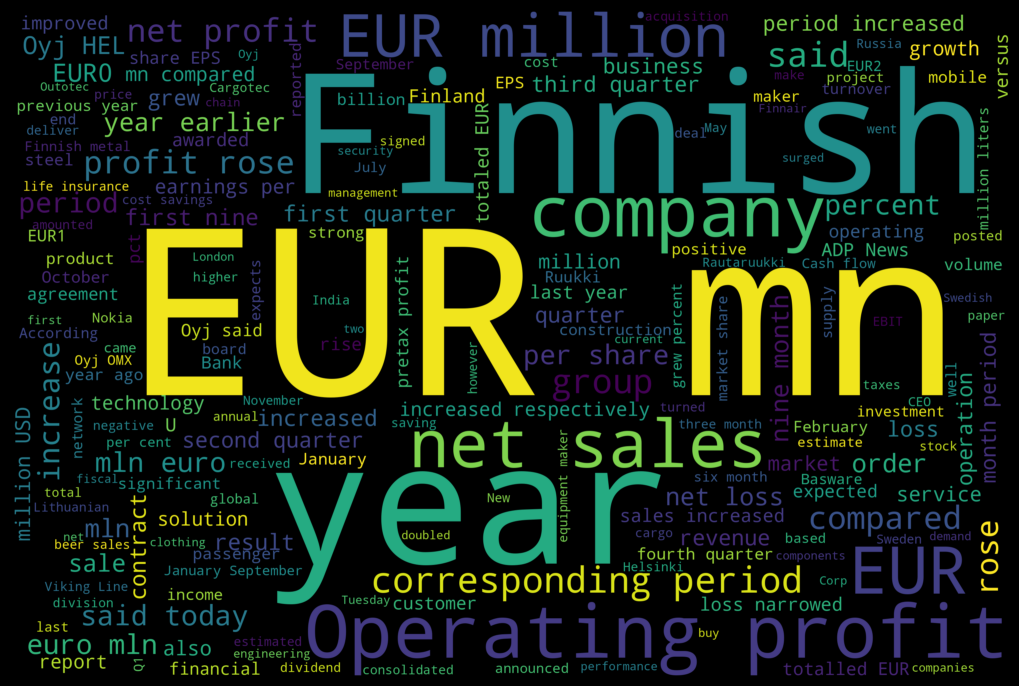

In [ ]:
plot_word_cloud(positive_data)

### **Interlude: Sentiment Analysis for Stock Prediction**

Let us stop to consider the impact of the intersection between the fields of NLP and Finance. Specifically, let us consider using the task of sentiment analysis for stock prediction.

The price of stocks fluctuate rapidly and are influenced dramatically by social media platforms. If there is positive or motivating news regarding a stock, many people may invest in it and cause price increases. Whereas if there is negative sentiment regarding a stock, peoples' investing patterns may cause the price to decrease!

A recent example is the monumental fluctuation in the stock price of GameStop Corp. (`GME`) influenced by Reddit. A movement started to increase the stock price and the resulting rhetoric, sentiment, and motivation urged thousands to join in and cause these massive changes as you can read more about [here](https://www.cnn.com/2021/01/30/business/gamestop-reddit-rebellion-explained/index.html).

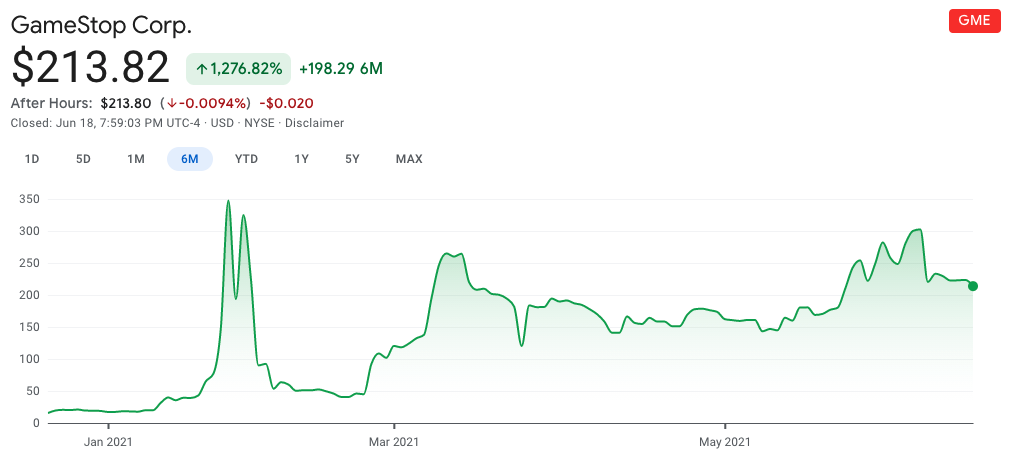

Stock price prediction using sentiment analysis is a well explored field, as you can read more about [here](https://medium.com/vsinghbisen/how-sentiment-analysis-in-stock-market-used-for-right-prediction-5c1bfe64c233). Before we can effectively create models to predict stock prices using sentiment analysis, we need to be able to accurately analyze sentiment of financial news. That will be our focus in these notebooks with the aim to create the best sentiment analysis financial news prediction models!

## Text Preprocessing

A signficant part of machine learning model development is properly filtering and processing data for use. The realm of NLP is especially prevalent with techniques to filter and clean text data in a variety of beneficial ways. We will take a look at and apply the techniques of **Sentence Filtering**, **Tokenization**, **Stemming**, and **Stopword Removal**. Let us take a look at each technique in turn before applying them all to our dataset.

#### **Regular Expressions**

Let us explore punctuation mark removal with a Python library named `regex`! A **RegEx**, otherwise known as a **Regular Expression**, is simply a special sequence of characters. We can use the `regex` Python library to replace, search for, or perform operations on any desired sequence of characters. First, let us take a look at the regular expression named `PUNCTUATION` below.

In [ ]:
print(PUNCTUATION)

!#$%&()*,-./:;<=>?@^_`{|}~


This is a regular expression of all the punctuation that may be used in the English language. How do we filter out all the punctuation from a sentence?

To do so, first create a sentence and save it in a variable named `sample_sentence`. Add as much punctuation as you'd like!

In [ ]:
sample_sentence = "Hi! How, are: you} doing?"

Now, we will use the `regex` library named `re` to filter out the punctuation. To do so, we need to make a `regex` object using the function `re.compile("[%s]" % PUNCTUATION)` and passing in our `PUNCTUATION` string as shown. Don't worry about the weird notation, as this is just a means of properly creating the regular expression object! Save the value this function returns in a variable named `PUNCTUATION_RE`.

In [ ]:
PUNCTUATION_RE = re.compile("[%s]" % PUNCTUATION)

Apply your regular expression object to your sentence to substitute punctuation characters with the empty string. Do so by calling the `.sub()` function on the `PUNCTUATION_RE` object as follows `PUNCTUATION_RE.sub("", sample_sentence)` and save the value this method returns in a variable named `filtered_sample_sentence`. Print your new sentence to see the results of your punctuation filtration!

In [ ]:
filtered_sample_sentence = PUNCTUATION_RE.sub("", sample_sentence)
print(filtered_sample_sentence)

Hi How are you doing


#### **Tokenization**

Tokenization is the process of splitting a string of text into a list of objects. We would like to split the sentences into these objects, which are words or punctuation, before proceeding with the analysis.

**Experiment with tokenization below!** Write any sentence you'd like in the parameter box below and run the cell to see the list of objects that the tokenizer creates from your input!

In [ ]:
#@title Tokenizing
sentence = "Your sentence here!\"" #@param {type:'string'}
tokens = word_tokenize(sentence)
tokens

['Your', 'sentence', 'here', '!', "''"]

#### **Lemmatization**


Lemmatization in NLP is the process of reducing words to their base or dictionary form, known as lemmas, by considering the context and part-of-speech (POS) information. Unlike stemming, which simply removes prefixes and suffixes, lemmatization aims to produce meaningful and linguistically accurate lemmas.

**Experiment with lemmatization below!** Write any word you'd like in the parameter box below and run the cell to see the generated lemma!

In [ ]:
#@title Lemmatize words { run: "auto", vertical-output: true, display-mode: "form" }
# Lemmatization
lemmatizer = WordNetLemmatizer()
word = "went" #@param {type:"string"}

pos_tag = nltk.pos_tag([word])[0][1][0].upper()
if pos_tag == 'J':
    pos_tag = 'a'

lemmatized_word = lemmatizer.lemmatize(word, pos=pos_tag.lower())
if lemmatized_word == word:
    lemmatized_word = lemmatizer.lemmatize(word, pos='v')

print(lemmatized_word)


go


#### **Stopword Removal**

Stopwords are English words that appear in several contexts, such as 'at', 'is', 'the', and so on. In NLP, it is usually advantageous to ignore these words, since they may add noise or cause numerical issues—and since they appear in *every* context, ignoring them will not impact the meaning of the sentence.


We've created a set called `STOPWORD_SET` that holds the most common stopwords in the English language. Print out this set and analyze some of the words you see. Are the stopwords what you expected? Are any of the stopwords strange? Comment on what you see!

In [ ]:
print(STOPWORD_SET)

{'over', "you'd", 'where', 'same', "should've", 'being', 'under', 'an', 'she', 'me', 'myself', 'until', 'so', "you'll", 'themselves', 're', 'herself', 'against', 've', 'him', 'into', 'of', 'shan', 'these', "she's", 'her', 'while', 'but', 'o', "haven't", 't', 'have', "you're", 'll', 'am', "that'll", 'no', "doesn't", 'been', 'in', 'now', 'were', 'too', 'as', 'before', 'don', 'didn', 'won', 'hers', 'again', 'was', 'any', 'more', 'nor', 'theirs', 'how', "won't", 'from', 's', "it's", 'mightn', 'only', 'above', 'm', 'because', 'yours', 'that', 'why', 'does', 'whom', 'those', 'below', 'hasn', 'who', 'and', 'during', "hadn't", 'can', 'ain', 'very', 'ours', "wouldn't", 'to', 'own', 'you', 'the', 'here', "shan't", 'wouldn', 'a', 'yourselves', 'when', 'doesn', 'be', 'there', 'your', 'isn', 'has', 'at', 'further', 'wasn', 'my', 'their', 'on', 'most', 'than', 'off', 'it', 'having', 'up', "shouldn't", "isn't", 'if', 'i', "wasn't", 'weren', 'this', "needn't", 'then', 'them', 'about', 'between', 'do',

**Experiment with stop-words below!** Write any word you'd like and check to see if it is a stopword or not!

In [ ]:
#@title Check If Stopword { run: "auto", vertical-output: true, display-mode: "form" }
word = "stopword\"" #@param {type:"string"}
if not word: raise Exception('Please enter a word')
eng_stopwords = set(stopwords.words('english'))
if word[:-1].lower().strip() in eng_stopwords: print('Yes,\"{}'' is a stopword.'.format(word))
else: print('No,\"{}'' is NOT a stopword.'.format(word))



No,"stopword" is NOT a stopword.


#### **Dataset Filtration**

We will use our techniques in **Tokenization**, **Stemming**, and **Stopword Removal** from above to filter our training and testing datasets. To get started, we will create a function named `remove_stopwords(sentence)` that takes a single tokenized sentence (list of token objects) and returns a new filtered list with all the stopwords removed. To make the filtration process possible, use `STOPWORD_SET`, a list of all the stopwords in the English language.

Take a look at the sample input and output below to help you create your function!

In [ ]:
#@title Sample Input and Output

print('Sample Input:\t{}'.format(SAMPLE_SENTENCE))
print('Sample Output:\t{}'.format(SAMPLE_SOLUTION))

Sample Input:	I need to remove all these meaningless stopwords.
Sample Output:	['need', 'remove', 'meaningless', 'stopwords']


In [ ]:
def remove_stopwords(full_sentence):
  no_punctuation_sentence = re.sub("[^a-zA-Z]", " ", full_sentence) #removes punctuation
  words = word_tokenize(no_punctuation_sentence) #tokenizes it & returns an array
  filtered_sentence = [] #initializes an array
  for w in words:
      if w.lower() not in STOPWORD_SET:
          filtered_sentence.append(w)
  return filtered_sentence

**Try calling your code on the sentence from above, named `SAMPLE_SENTENCE`, to verify that you get the same output!**

In [ ]:
print(SAMPLE_SENTENCE)

I need to remove all these meaningless stopwords.


In [ ]:
remove_stopwords(SAMPLE_SENTENCE)

['need', 'remove', 'meaningless', 'stopwords']

Now, we will apply the filtration to our entire training and testing datasets! To do so, call the `preprocess_data(DATA)` function passing in `df_train` for data. This function will return a list of all the filtered sentences and their respective labels: so, save this result two variables named `train_sentences` and `train_labels`. Thereafter, print the first few elements of `train_sentences` to assess your preprocessing!

In [ ]:
train_sentences, train_labels = preprocess_data(df_train)

Similarly preprocess your test data and save the result in a variable named `test_sentences`. Print the first few elements of `test_sentences` to assess the preprocessing.

In [ ]:
test_sentences, test_labels = preprocess_data(df_test)

# **Build a baseline model for the task of financial news sentiment classification.**

In the world of machine learning, we want to be able to create models quickly and iterate on them continuously to rapidly arrive at solutions to our problems. To start us off, we will begin with a simple and quick-to-implement model to analyze our financial news sentences: Logistic Regression!

In [ ]:
#@title Exploration Exercise: Brainstorm the benefits of a Logistic Regression model and why it may be useful to use for this application?

_1_ = '' #@param {type:"string"}
_2_ = '' #@param {type:"string"}
_3_ = '' #@param {type:"string"}

print('1: It is a simple baseline models that tells us how much room there is to improve.')
print('2: Model iteration is quick and easy.')
print('3: Logistic regression is interpretable. It is often extremely important that you are able to understand why a model is making specific predictions, and Logistic Regression gives us this ability.')

## Engineering features

Part of the NLP process is the creation of features from language data. Now that we have fully filtered our input sentences, we can now take the next step to generate feature vectors for each of the examples to use in our ML model. To create features from the filtered input sentences, we will use a technique you are already familiar with: **Bag of Words**! Recall that Bag of Words is a manner of transforming text into computational data by recording the frequency of words. This process is referred to as vectorization.

Consider **Sentence A** below and its conversion to a vector representation.

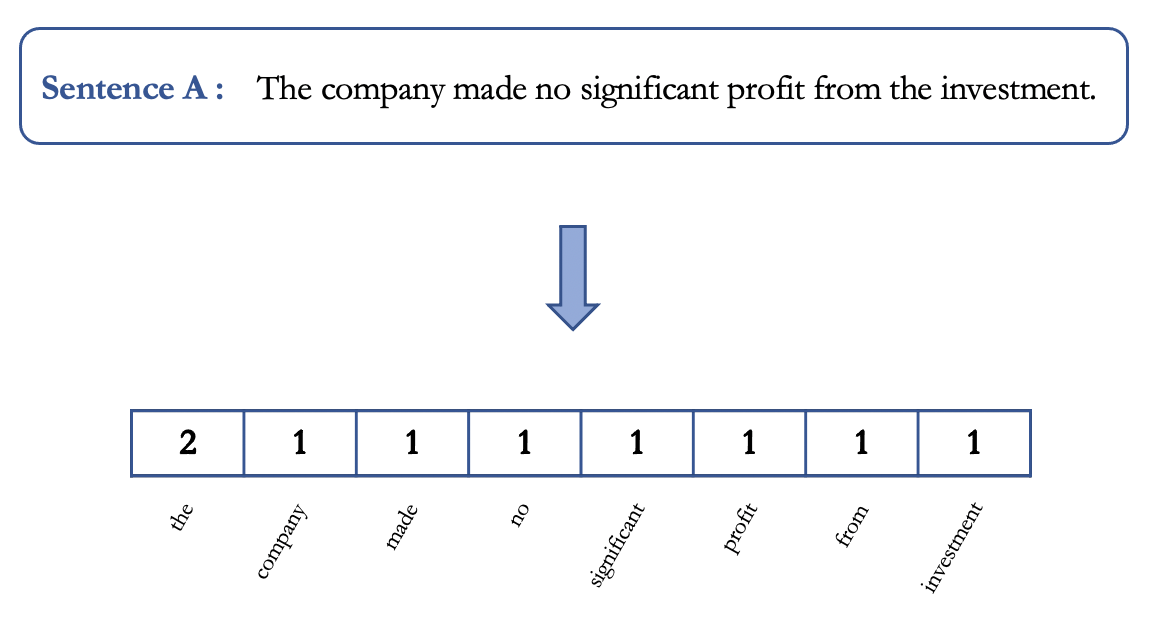

#### **Bag-of-Words using CountVectorizer**

To carry out Bag-of-Words, we will be using an object known as a `CountVectorizer` from the `sklearn` library. A `CountVectorizer` is used to convert a collection of text (in our case, a list of financial news sentences) into a vector of word counts. It also enables us to ​pre-process our text before turning it into a vector. This makes `CountVectorizer` a highly flexible way to represent text as numerical input.

Before applying the `CountVectorizer` to our data, let us take a look at how to use it!

In [ ]:
# List of sentences
all_sentences = ["Google AI made remarkable achievements in 2019.", "Google Stock was at its all time high"]

#Create instance of CountVectorizer() object
vectorizer = CountVectorizer()

`CountVectorizer`'s `.fit()` method learns about the text (its length, vocabulary, etc.).

In [ ]:
# Tokenizes the text and builds the vocabulary
vectorizer.fit(all_sentences)

CountVectorizer()

`CountVectorizer`'s vocabulary_ attribute is a dictionary that contains our words (keys) and their index (value). The indices of the words are sorted based on their ASCII value. For more details on ASCII sort order, you may also refer to [this resource](http://support.ecisolutions.com/doc-ddms/help/reportsmenu/ascii_sort_order_chart.htm).

In [ ]:
print(vectorizer.vocabulary_)

{'google': 5, 'ai': 2, 'made': 9, 'remarkable': 10, 'achievements': 1, 'in': 7, '2019': 0, 'stock': 11, 'was': 13, 'at': 4, 'its': 8, 'all': 3, 'time': 12, 'high': 6}


`CountVectorizer`'s `.transform()` method turns the sentences into their Bag-of-Words vector representations.

In [ ]:
# Encode sentences as a vectors
bag_of_words_matrix = vectorizer.transform(all_sentences).toarray()

# Print vectors
print(bag_of_words_matrix)

[[1 1 1 0 0 1 0 1 0 1 1 0 0 0]
 [0 0 0 1 1 1 1 0 1 0 0 1 1 1]]


Print the shape of `bag_of_words_matrix` initialized above. What does this tell you about the count of words among all the text sentences?

## Logistic Regression for Sentiment Classification

Now we will piece together our preprocessing techniques to create and run our model!

#### **Train your model!**

Vectorize your data below using the `CountVectorizer`. Thereafter, train a `LogisticRegression()` passing in your training data matrix and labels.

In [ ]:
def train_model(train_sentences, train_labels):
  train_sentences = [" ".join(t) for t in train_sentences]
  train_labels = [l for l in train_labels]

  # vectorizer = initialize CountVectorizer
  vectorizer = CountVectorizer()

  # train_vect = get the vector representation of train_sentences using the .fit() and .transform() methods
  vectorizer.fit(train_sentences)
  train_vect = vectorizer.transform(train_sentences)

  # model = initialize a Logistic Regression model
  model = LogisticRegression()

  # Train with train_vect and train_labels using the .fit() method of LogisticRegression
  model.fit(train_vect, train_labels)

  return model, vectorizer

Try running your code to train your model! Call your `train_model()` function, passing in your previously initialized `train_sentences` and `train_labels` from above. Save the result in variables named `model` and `train_vectorizer`.

In [ ]:
model, train_vectorizer = train_model(train_sentences, train_labels)

#### **Test your model!**

Fill out the code below to get the vector representation of the test sentences and evaluate the accuracy of the model.

In [ ]:
def predict(test_sentences, test_labels, vectorizer, model):
  test_sentences = [" ".join(t) for t in  test_sentences]

  # test_vect = get the vector representation of test_sentences using vectorizer's .transform method (no need to use .fit!)
  test_vect = vectorizer.transform(test_sentences)

  # preds = predict the labels of test_sentences using the model's predict method on test_vect
  preds = model.predict(test_vect)

  acc = metrics.accuracy_score(test_labels, preds)
  return preds, acc

Try running your code to test your model! Call your `predict()` function, passing in your previously initialized `test_sentences`, `test_labels`, `train_vectorizer`, and `model` from above. Save the predicitions and accuracy result in variables named `y_predictions` and `test_accuracy`. Print the accuracy results to assess your performance!

In [ ]:
y_predictions, test_accuracy = predict(test_sentences, test_labels, train_vectorizer, model)
print(test_accuracy)

0.8458149779735683


# **Assess and visualize our results using a confusion matrix.**



Running a model and obtaining great results is beneficial and important. However, being able to understand the significance of your results is arguably more important. A foundational understanding of your results can help you to iterate over and improve on your model. Let us take some time to create and understand the confusion matrix results of our classification model.

Plotting the Confusion Matrix


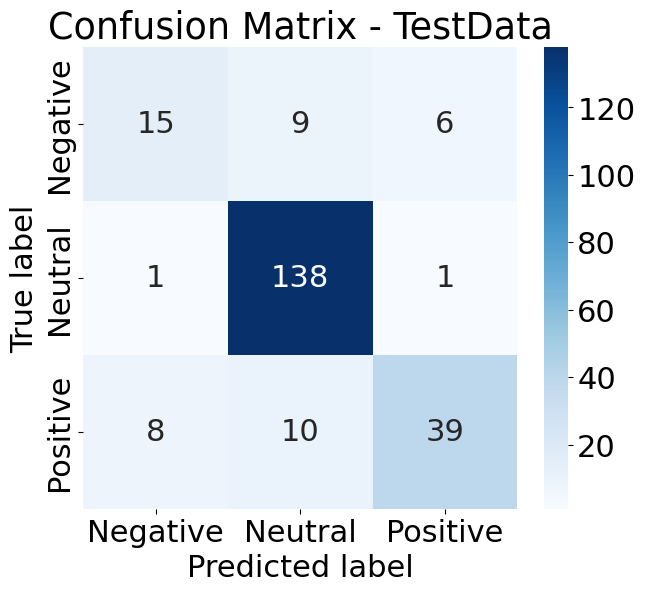

In [ ]:
plot_confusion_matrix(test_labels, y_predictions)